# Exercise Sheet 5 - Segmentation & Denoising with U-Net

 * Deep Learning for Computer Vision - Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Mon, Jan 16, before 14:00**

In this assignment we will use a U-Net for two different tasks:

*   List item
*   List item


- semantic and instance segmentation of nuclei in microscopy images
- denoising of natural images

## Hints

The goal of the first part of the exercise (segmentation) is to implement the U-Net architecture very similar to the original publication and then use it for its initial purpose, semantic segmentation. In the second part we will use the same U-Net implementation, but use it for a different task: denoising, following the ideas of noise-to-noise. 

To understand the background of this exercise you can:

* Review the lecture (Lecture 7 for U-Net architecture, Lecture 8 for noise-to-noise)
* Read the [U-net publication](https://arxiv.org/abs/1505.04597).
* Read the [noise-to-noise publication](https://arxiv.org/abs/1803.04189).

Note that we will implement the same ideas as in these papers, but will deviate from the implementation details and conduct different and fewer experiments.
 
*Do not hesitate to ask questions and ideally discuss them with the fellow students on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck.*

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>\_\<surname2\>\_\<surname3\>.ipynb
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 5`.
- Make only one submission of the exercise per group.
- The deadline is strict
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.


**Import required libraries.**

In [ ]:
import os
import zipfile
from glob import glob
from pathlib import Path

#import imageio.v2 as imageio
import imageio as imageio

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from matplotlib import colors
from scipy.optimize import linear_sum_assignment
from skimage.measure import label
from skimage.metrics import contingency_table, peak_signal_noise_ratio
from skimage.segmentation import find_boundaries, watershed
from skimage.util import random_noise


In [ ]:
# create a root folder where to save the data for this exercise in Kaggle
root_folder = "/kaggle/working/dlforcv-ex5"
os.makedirs(root_folder, exist_ok=True)

## Segmentation

In the first part of the exercise we will implement the U-Net architecture and apply it to a segmentation problem in microscopy: segmenting nuclei in fluorescence images. The data we are using is a subset of the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

### Data preparation

In [ ]:
# download the data
data_folder = os.path.join(root_folder, "kaggle-data")
url = "https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    tmp_path = os.path.join(data_folder, "data.zip")
    with requests.get(url) as r:
        with open(tmp_path, "wb") as f:
            f.write(r.content)
    with zipfile.ZipFile(tmp_path, "r") as f:
        f.extractall(data_folder)
    os.remove(tmp_path)
data_folder = os.path.join(data_folder, "dsb2018")
assert os.path.exists(data_folder)

**Data exploration**

The data is stored in the root folder `dsb2018` and contains the two subfolders `train` and `test` with train/test split. Each of these folders contains the folders `images` with the raw image data and `masks` with the instance masks. As a first step, we will visualize some of the images and labels from the training data.

In [ ]:
image_paths = glob(os.path.join(data_folder, "train", "images", "*.tif"))
image_paths.sort()
mask_paths = glob(os.path.join(data_folder, "train", "masks", "*.tif"))
mask_paths.sort()
assert len(image_paths) == len(mask_paths)

In [ ]:
# a function to generate a random color map for a label image
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap

In [ ]:
def plot_sample(image_path, mask_path):
    image, mask = imageio.imread(image_path), imageio.imread(mask_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(image, cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

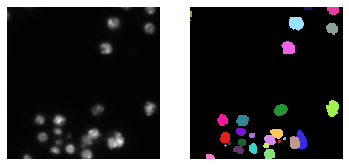

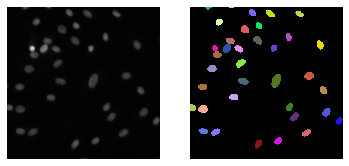

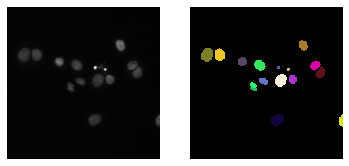

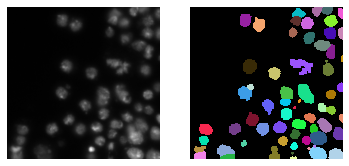

In [ ]:
# plot the first 4 images
for i in range(4):
    plot_sample(image_paths[i], mask_paths[i])

You should see 4 images with nuclei and the corresponding colored nuclei masks. To further understand and explain the data, please answer the following QUESTIONS:
- Do the ids assigned to the individual nuclei (= colors in the 2nd column of images) have a fixed meaning? In other words, would the segmentation change if we change shuffle these numbers, so that all pixels labeled `1` are labeled `2` and so on?

Ans. The labels do not have a fixed meaning. Segmenting would yeild the same result regardless of relabeling. 
- Can we directly use a U-Net to predict the mask ids? Why / Why not?

Ans. 
- Find the unique shapes of the images in the training set.

Ans. Unique Shapes ->
[[512 640]
 [260 347]
 [360 360]
 [520 696]
 [256 256]
 [256 320]]
- Do all images have the same shape? If not, can this lead to problems? How could we deal with potentially arising problems?

Ans. No they are not. 

In [ ]:
# TODO find how many images we have in the training set
# and find all (unique) shapes of the images in the training set

train_num_img = len(image_paths)

image_shape = []
# for all images 
for i in range(0,train_num_img):
  shapes = imageio.imread(image_paths[i]).shape
  image_shape.append(shapes)

# for unique shapes 
unique_shapes = np.array(list(set(image_shape)))
print("UNIQUE SHAPES : \n", unique_shapes,"\n")

print("#IMAGES IN TRAINING SET -> ", train_num_img)


UNIQUE SHAPES : 
 [[512 640]
 [260 347]
 [360 360]
 [520 696]
 [256 256]
 [256 320]] 

#IMAGES IN TRAINING SET ->  447


TODO your answer here

In [ ]:
# TODO now load the images and masks into memory, and normalize the images so that they have zero mean and unit variance
images = []
masks = []

for i in range(train_num_img):
  images.append(imageio.imread(image_paths[i]))
  masks.append(imageio.imread(mask_paths[i]).astype(np.float32))


In [ ]:
ims_flat = np.concatenate([im.ravel() for im in images])
mean, std = np.mean(ims_flat), np.std(ims_flat)
images = [(im.astype(np.float32) - mean) / std for im in images]

v_idx = list(range(19,train_num_img,20))
train_idx = list(set(range(train_num_img))-set(v_idx))

In [ ]:
# TODO make a train validation split, use every 20th image for validation
train_images = []
train_masks = []
val_images = []
val_masks = []

for i in train_idx:
  train_images.append(images[i])
  train_masks.append(masks[i])

for i in v_idx:
  val_images.append(images[i])
  val_masks.append(masks[i])




# improvement on the solution because it asked every 20th image to be in validation

# # Create a validation set by selecting every 20th image
# validation_indices = np.arange(0, len(images), 20)
# val_images = images[validation_indices]
# val_masks = masks[validation_indices]

# # # Create a train set by removing the validation images
# train_images = np.delete(images, validation_indices, axis=0)
# train_masks = np.delete(masks, validation_indices, axis=0)

In [ ]:
# finally, let's choose the appropriate torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Implement PyTorch dataset**

As a next step, we implement a `torch.utils.data.Dataset` to have access to our data during training. As you shoulD have realized in the previous question, the images in our training set come in different sizes. In order to concatenate batches, we however need images of the same size. To solve this issue, we will subsample patches of size 256 x 256 (smallest image size) from the images in the dataset.

In [ ]:
class NucleiDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, transform=None):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.images[index], self.masks[index]

        # crop the images to have the shape 256 x 256, so that we can feed them into memory
        # despite them having different sizes
        crop_shape = (256, 256)
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            image, mask = image[crop], mask[crop]
              
        # apply the transforms if given
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        if self.transform is not None:
            image, mask = self.transform(image, mask)
        
        # make sure we have numpy arrays and add a channel dimension for the image data
        image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]
        return image, mask
        
    def __len__(self):
        return len(self.images)

As discussed in the lecture, we can't learn the instance segmentation directly. So we will first start with a semantic segmentation problem and learn foreground background segmentation with the U-Net, i.e. predict for each pixel whether it belongs to a nucleus or to the background. To this end, implement a `mask_transform` that converts the instance segmentation ground-truth into a binary target and pass it to the training dataset.

In [ ]:
# TODO implement a transform that outputs the binary target 
# and instantiate the training dataset and validation dataset with it
# HINT: the transform can be a function that takes the mask array as input and returns the binarized version
# HINT: you will also need to add a channel dimension to the target

# mask_transform
def mask_transform(image):
  img_cpy = np.copy(image)
  img_cpy[img_cpy > 0 ] = 1
  return np.expand_dims(img_cpy,axis=0)
                   
train_dataset = NucleiDataset(images = train_images, masks = train_masks, mask_transform=mask_transform)
val_dataset = NucleiDataset(images = val_images, masks = val_masks, mask_transform=mask_transform)

In [ ]:
# TODO sample a few images from the dataset and verify that they are correct

def plot_sample(dataset,idx):
  image, mask = dataset.__getitem__(idx)
  fig, ax = plt.subplots(1, 2)
  ax[0].axis("on")
  ax[0].imshow(np.squeeze(image))

  # visualize 
  ax[1].axis("on")
  ax[1].imshow(np.squeeze(mask))
  plt.show()

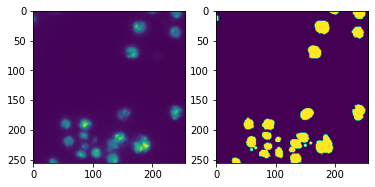

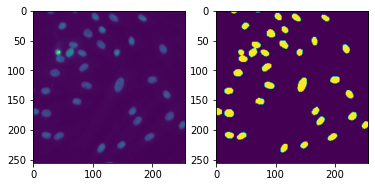

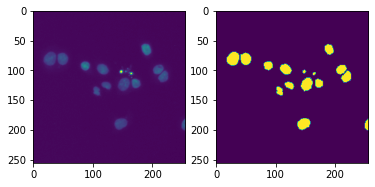

In [ ]:
for i in range(3):
    plot_sample(train_dataset, i)

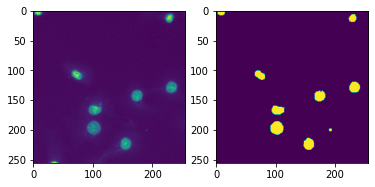

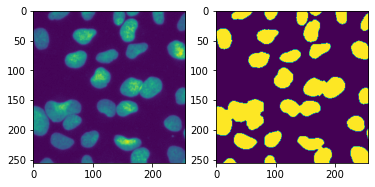

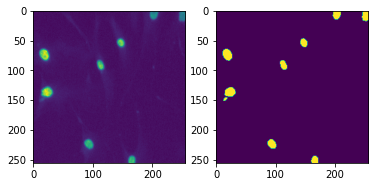

In [ ]:
for i in range(3):
    plot_sample(val_dataset, i)

The images you sample should look similar to this (using the standard colormap for the binarized mask):

![image.png](attachment:image.png)

### Implement the U-Net

Next, we will implement a U-Net architecture inspired [Ronneberger et al.](https://arxiv.org/abs/1505.04597), see the image below.

IMPORTANT: unlike in the publication / image we will use SAME convolutions, so that the input shape is the same as the output shape. This will introduce some boundary artifacts, but it will make implementing the rest of this exercise much simpler.
It also means that you don't need to crop the features passed on in the skip connections and can directly concatenate them.

![unet2d-architecture.png](attachment:unet2d-architecture.png)

HINTS: 
- the `up-conv` used here is called [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#convtranspose2d) in PyTorch.
- you can concatenate the features coming from the skip connectins and the encoder with `torch.cat`
- you will need `nn.ModuleList` to store the individual blocks of the encoder / decoder

Before you implement the U-Net, please answer the following QUESTIONS:
- What kind of architecture is the U-Net and what is the rationale behind this architecture?
- What other types of architectures for semantic segmentation exist to achieve similar effects?
- Why are the skip connections used in the U-Net?

TODO your answers here

In [ ]:
#1) it is skip-connection. It solves the problem of accuracy degradation. The problem of accuracy degradation lies in the fact that as the network depth increases, the accuracy first increases, then reaches a plateau, and then even begins to decrease.
#so, being able to pass the signal without transformations, the model should at least be no worse than its less deep version.

#2)  Holistically nested edge detection: multi-scale feature combinations
# DeepLab: atrous convolutions and spatial pyramid pooling
# Hierarchical Multi-Scale Attention: multi-scale attention mechanism

#3) to copy high-resolution information into decoding path

In [ ]:
sample = nn.ConvTranspose2d(1024,1024,kernel_size=2,stride=2)
input = torch.randn(2, 1024, 28, 28)
output = sample(input)

In [ ]:
# TODO implement the U-Net architecture
class special_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        return x



class encoder_block(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.enc_blocks = nn.ModuleList([special_block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        save_res = []
        for i in range(len(self.channels)-1):
            x = self.enc_blocks[i](x)
            save_res.append(x)
            x = self.pool(x)

        return save_res


class decoder_block(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.upsample = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2) for i in range(len(channels)-1)])
        self.dec_blocks = nn.ModuleList([special_block(channels[i], channels[i+1]) for i in range(len(channels)-1)]) 

    def forward(self, x, skip):
        for i in range(len(self.channels)-1):
            x = self.upsample[i](x)
            x = torch.cat([x, skip[i]], dim=1)
            x = self.dec_blocks[i](x)
        return x



class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.encoder = encoder_block([in_channels, 64, 128, 256, 512, 1024])
        self.decoder = decoder_block([1024, 512, 256, 128, 64])
        self.outputs = nn.Conv2d(64, out_channels, 1)


    def forward(self, inputs):
        to_save = self.encoder(inputs)
        out = self.decoder(to_save[-1], to_save[::-1][1:])
        outputs = self.outputs(out)

        return outputs

0


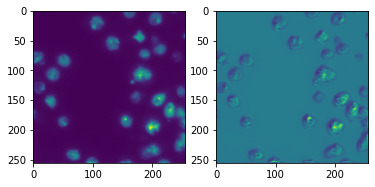

In [ ]:
# TODO display the prediction. Can you interpret the resulting image?
def plot_sample_to_check(image, mask):
  fig, ax = plt.subplots(1, 2)
  ax[0].axis("on")
  ax[0].imshow(np.squeeze(image))
  # visualize 
  ax[1].axis("on")
  ax[1].imshow(np.squeeze(mask))
  plt.show()


model = UNet()
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
for i, (x, y) in enumerate(train_loader):
  if(i == 0):
    print(i)
    x = x.to(device)
    Y_pred = model(x)
    Y_pred = Y_pred.cpu().clone()
    x = x.cpu().clone()
    Y_pred = Y_pred.detach().numpy()
    plot_sample_to_check(x, Y_pred)

So we can not interpret the resulting image because we can not see any signs of segmentation 

## Training

Now we can define the training functions, similar to the last exercise, and then plot the results of loss and metrics

## Discussion:
Another way to monitor the loss, metrics and images during training and validation is [tensorboard](https://www.tensorflow.org/tensorboard). Note that usually the data for tensorboard is stored separately from the notebook files/scripts, so if you copy the scripts somewhere else you will not see the curves in tensorboard anymore.

In [ ]:
# in this cell all the training and validation functions are implemented for you already;
# these implementations are fairly similar to the exercise where we trained a CNN on CIFAR

# normalize a tensor to range [0, 1] (per channel).
# this is needed to properly display the tensor as an image in tensorboard
def normalize(tensor):
  eps = 1e-6
  normed = tensor.numpy()
  minval = normed.min(axis=(0, 2, 3), keepdims=True)
  normed = normed - minval
  maxval = normed.max(axis=(0, 2, 3), keepdims=True)
  normed = normed / (maxval + eps)
  return torch.from_numpy(normed)

# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        if metric is not None:
            metric_value = metric(pred, y)


# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    n_val = len(loader)
    metric_value, loss_value = 0.0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value += loss(pred, y).item()
            if metric is not None:
                metric_value += metric(pred, y).item()
        
    metric_value /= n_val
    loss_value /= n_val
    return(metric_value, loss_value)

# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs
):
    metrics = []
    losses = []
    epoch_len = len(train_loader)
    step = 0
    for epoch in tqdm.trange(n_epochs):
        train_epoch(model, train_loader, loss, metric, optimizer)
        step = epoch_len * (epoch + 1)
        metr, loss_meaning = validate(model, val_loader, loss, metric)
        metrics.append(metr)
        losses.append(loss_meaning)
    return(metrics, losses)

We will use (per-pixel) binary cross entropy as a loss function. Pytorch offers to different implementations of this loss: [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) and [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

HINTS:
- The targets for BCE should be 'float32' values

QUESTIONS:
- What is the difference between the two different implementations? - BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss
imporvement on the answer:

BCEWithLogitsLoss combines a Sigmoid activation function and the Binary Cross-Entropy Loss (BCE) into a single function,  it takes the logits of the model's output, applies the Sigmoid function and then calculates the BCE loss between the resulting probability and the true labels. any real value output, and not just the probability between 0 and 1.
BCELoss takes the model's output after the sigmoid activation function as input and calculates the BCE loss between this output and the true labels. This means that the output of the model should already be in the range of [0,1]


- Which one do we need to use here, and why? - as i understand, as far as we do not use activation as the last step in our UNet, we have to use BCEWithLogitsLoss. - we need to put predictions into [0, 1] (formula of BCELoss)


BCEWithLogitsLoss would be a better choice because it can handle logits as input, and it can handle the case where the model's output is not in the range of [0, 1].

TODO your answers here

In [ ]:
# TODO create the loss function
loss = nn.BCEWithLogitsLoss()

Next, we want to define a suitable metric for measuring the quality of the (binary) network prediction. We will use the [dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for this, which compares the intersection of prediction and target to their union.

In [ ]:
# TODO implement the dice score as a function.
# HINTS: 
# - for later parts of this exercises, you should implement it in such a way that
# the function can compute the dice score for input and target with multiple channels,
# and so that it is computed independently per channel and the channel average is returned
# - since we don't have an activation in the U-Net you need to bring the predictions in range [0, 1] using torch.sigmoid
# - the dice score can be formulated for continuous predictions in [0, 1]; DO NOT threshold the predictions

def dice_score(input_, target):
  ans = []
  input_ = torch.sigmoid(input_)
  for i in range(input_.size()[1]):
    #print(input_[0][i]) --- unkomment to chech if dice score is correct
    input_new = input_[0][i].view(-1)
    target_new = target[0][i].view(-1)
        
    intersection = (input_new * target_new).sum()                            
    ans.append((2. * intersection)/(input_new.pow(2).sum() + target_new.pow(2).sum()))  
        
  return 1 - sum(ans) / len(ans)


In [ ]:
1 - (4 * 0.7311 * 2 /(4*(0.7311 ** 2) + 4) + 2 * (0.7311 * 2 + 0.5) / (3*(0.7311 ** 2) + 0.5**2 + 3)) / 2

0.11927663547192302

In [ ]:
import torch 
# TODO check your dice implementation for an example model prediction and the corresponding target
fir = torch.tensor([[
          [[1, 1],
          [1, 1]],
         [[1, 0],
          [1, 1]]
         ]]) 

sec = torch.tensor([[
          [[1, 1],
          [1, 1]],
         [[1, 1],
          [0, 1]]
         ]]) 
print(dice_score(fir, sec))

tensor(0.1193)


In [ ]:
# train the model for 10 epochs, 
# after the training, check the plots to see how the model loss and metrics evolve,
# and to see predictions of the training data in real time
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
m, l = run_training(model, train_loader, val_loader, loss, dice_score, optimizer, n_epochs)

100%|██████████| 10/10 [04:45<00:00, 28.58s/it]


0


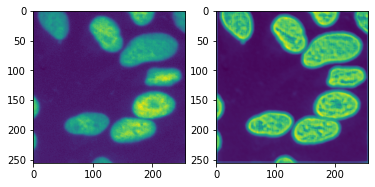

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
for i, (x, y) in enumerate(train_loader):
  if(i == 0):
    print(i)
    x = x.to(device)
    Y_pred = model(x)
    Y_pred = Y_pred.cpu().clone()
    x = x.cpu().clone()
    Y_pred = Y_pred.detach().numpy()
    plot_sample_to_check(x, Y_pred)

    #Now we can see some signs of segmentation

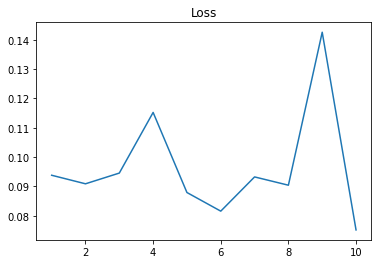

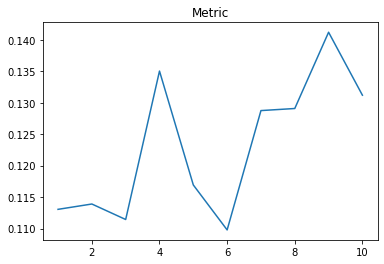

In [ ]:
epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(epoch, l)
plt.title("Loss")
plt.show()
plt.plot(epoch, m)
plt.title("Metric")
plt.show()

## Evaluate on test data

Now, we will evaluate the **instance segmentation**  derived from the model predictions on the test data. To this end, we will use [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)#Algorithms) to convert the (binarized) network predictions into an instance segmentation. We will use the implementation from [skimage](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label).

QUESTION:
- Describe briefly what the connected components algorithm does when applied to a (binary) image. (You don't need to comment on the 'how' (implementation)).

- Answer: The connected component analysis (CCA) algorithm is a method used to identify and extract connected regions of an image. When applied to a binary image, the CCA algorithm groups together all the pixels that have the same value (either 0 or 1) and are connected to each other. Connected pixels are defined as those that share a common side or corner, i.e. they are 8-connected or 4-connected depending on the implementation.

TODO: your answer here

In [ ]:
# TODO load and normalize the test images
test_images = []
test_masks = []

image_test_paths = glob(os.path.join(data_folder, "test", "images", "*.tif"))
image_test_paths.sort()
mask_test_paths = glob(os.path.join(data_folder, "test", "masks", "*.tif"))
mask_test_paths.sort()

test_num_img = len(image_test_paths)

for i in range(test_num_img):
    # Load the image
    image = imageio.imread(image_test_paths[i]).astype(np.float32)
    # # Convert the image to a numpy array
    image = np.array(image)
    # # Normalize the image
    image = image / 255.0
    # Append the image to the list
    test_images.append(image)
    # Load the mask
    mask = imageio.imread(mask_test_paths[i]).astype(int)
    # # Convert the mask to a numpy array
    mask = np.array(mask)
    # # Normalize the mask
    # mask = mask / 255.0
    # Append the mask to the list
    test_masks.append(mask)


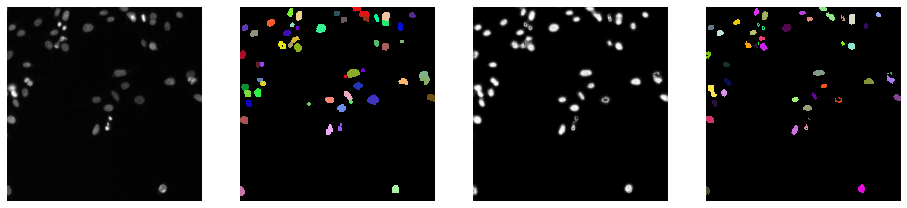

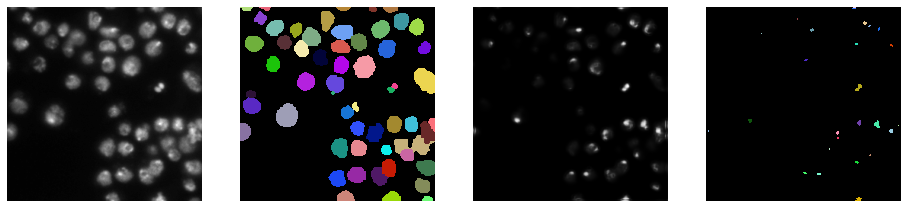

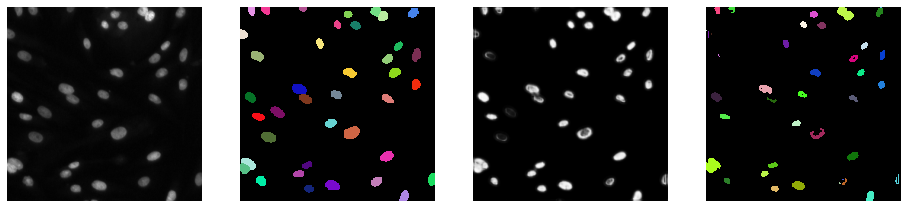

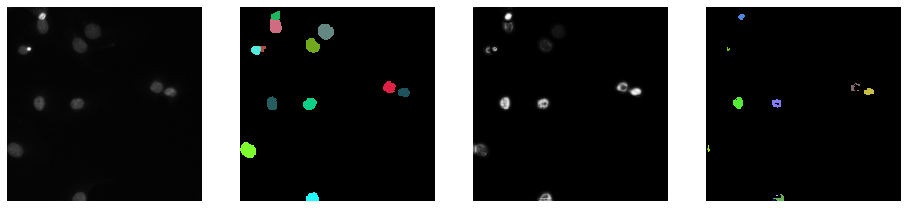

In [ ]:
# check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in zip(test_images, test_masks):
        if counter > 3:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(torch.from_numpy(im[None, None]).to(device))
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        nuclei = label(pred > 0.5)
        fig, ax = plt.subplots(1, 4, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im, cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
        ax[2].axis("off")
        ax[2].imshow(pred, cmap="gray")
        ax[3].axis("off")
        ax[3].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        plt.show()
        counter += 1

In [ ]:
# we also need a measure for the instance segmentation quality.
# here, we use intersection over union (for each ground-truth object).
# it is implemented for you already below

def precision(tp, fp, fn):
    return tp / (tp + fp) if tp > 0 else 0


def compute_ious(seg, mask):
    overlap = contingency_table(seg, mask).toarray()
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    eps = 1e-7
    ious = overlap / np.maximum(n_pixels_pred + n_pixels_true - overlap, eps)
    # ignore matches with zero (= background)
    ious = ious[1:, 1:]
    n_pred, n_true = ious.shape
    n_matched = min(n_pred, n_true)
    return n_true, n_matched, n_pred, ious

    
def compute_tps(ious, n_matched, threshold):
    not_trivial = n_matched > 0 and np.any(ious >= threshold)
    if not_trivial:
        # compute optimal matching with iou scores as tie-breaker
        costs = -(ious >= threshold).astype(float) - ious / (2*n_matched)
        pred_ind, true_ind = linear_sum_assignment(costs)
        assert n_matched == len(true_ind) == len(pred_ind)
        match_ok = ious[pred_ind, true_ind] >= threshold
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0
    return tp


def intersection_over_union(seg, mask, threshold=0.5):
    if seg.sum() == 0:
        return 0.0
    n_true, n_matched, n_pred, ious = compute_ious(seg, mask)
    tp = compute_tps(ious, n_matched, threshold)
    fp = n_pred - tp
    fn = n_true - tp
    ap = precision(tp, fp, fn)
    return ap

In [ ]:
# Compute the average IOU of all the test images
ious = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # the model can only predict images with a spatial size that is divisible by 16
        # if it isn't we just cat a few pixels to make it fit
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        labels = label(pred > 0.5)
        
        iou = intersection_over_union(labels, mask)
        ious.append(iou)
print()
print("Mean IoU:", np.mean(ious))



100%|██████████| 50/50 [00:02<00:00, 18.99it/s]


Mean IoU: 0.27780195515124106


QUESTION:
- Given the samples of the instance segmentations from above, what are the biggest sources of error you can identify in the model predictions / instance segmentation approach?
- How could they be overcome?

TODO your answer here

# sources of error
There are several sources of error that can occur in instance segmentation models and their predictions:

1. Annotation errors: Incorrect or inconsistent annotation of training data can lead to errors in model predictions.

2. Limited diversity in training data: If the training data is not diverse enough, the model may not generalize well to new images or scenes.

3. Overfitting: If the model is too complex or trained for too long, it may memorize the training data rather than learning to generalize to new data.

4. Lack of context: Instance segmentation models may struggle to identify objects in context, such as determining the location of an object in a scene or its relationship to other objects.

5. Scale variation: Models can struggle with objects of different sizes, and may require additional training data to handle objects of varying scales.

6. Occlusion: If an object is partially or fully occluded by another object, it can be difficult for a model to identify and segment it.

7. Lighting variations: Lighting variations in the image can cause errors in model predictions.

8. Class imbalance: If there is a large imbalance between the number of instances of different object classes in the training data, the model may not perform well on the less represented classes.

9. Sensitivity to initialization: Some models may have poor performance if they are not initialized with good parameters.

10. Limited ability to handle complex object shapes: Some models may not handle complex object shapes well.

# How to overcome the errors

1. Annotation errors: To overcome annotation errors, it is important to have a rigorous annotation process in place, with clear guidelines and quality checks to ensure the accuracy and consistency of the annotations.

2. Limited diversity in training data: To overcome the limited diversity in training data, it is important to have a diverse set of training images that represent different scenarios and variations, such as different lighting conditions, object scales, and occlusions.

3. Overfitting: To prevent overfitting, it is important to use regularization techniques such as dropout and early stopping, as well as using cross-validation to monitor the performance of the model during training.

4. Lack of context: To overcome the lack of context, it is important to use contextual information, such as object relationships and scene layouts, in the model design and training.

5. Scale variation: To handle scale variation, it is important to use data augmentation techniques such as random scaling, cropping and rotation during training.

6. Occlusion: To handle occlusion, it is important to use techniques such as part-based models, attention mechanisms, and multiple instance learning to help the model identify occluded objects.

7. Lighting variations: To handle lighting variations, it is important to use data augmentation techniques such as random brightness and contrast changes during training.

8. Class imbalance: To handle class imbalance, it is important to use techniques such as resampling, class-weighted loss functions, and cost-sensitive learning to balance the class distribution in the training data.

9. Sensitivity to initialization: To overcome sensitivity to initialization, it is important to use techniques such as warm restarts, or pre-training the model on other related tasks.

10. Limited ability to handle complex object shapes: To handle complex object shapes, it is important to use more advanced models such as deformable convolutional networks, and to provide the model with more training data with complex shapes.


## Train with boundary channel

To avoid merges of touching nuclei, we will now add a boundary channel to the learning objective, and then use it for object separation in the instance segmentation funtion. To this end, we will train a U-Net that outputs 3 channels (background, foreground, object boundary) and use the cross entropy loss.

In [ ]:
# TODO implement a transform that outputs an image with 3 values:
# 0 for backgorund, 1 for foreground (= nucleus) and 2 for boundary (boundary pixel between nucleus and background or between 2 nuclei)
# HINT: you can use skimage.segmentation.find_boundaries (already imported) to determine the boundary pixels
def label_transform(mask):
  boundries = find_boundaries(mask, mode='inner').astype(np.uint8)
  nuclei = (mask > 0).astype(np.uint8)

  return (nuclei + boundries).astype(int)

In [ ]:
# instantiate the training and validation datasets with the new label transform
train_dataset = NucleiDataset(
    train_images, train_masks, mask_transform=label_transform
)
val_dataset = NucleiDataset(
    val_images, val_masks, mask_transform=label_transform
)

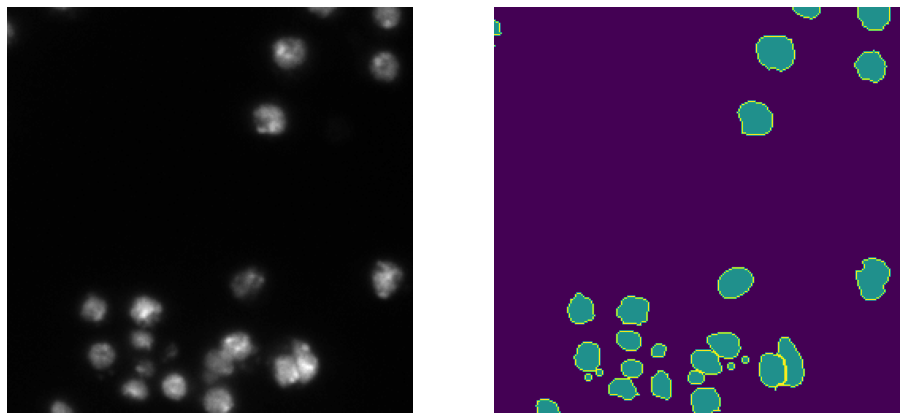

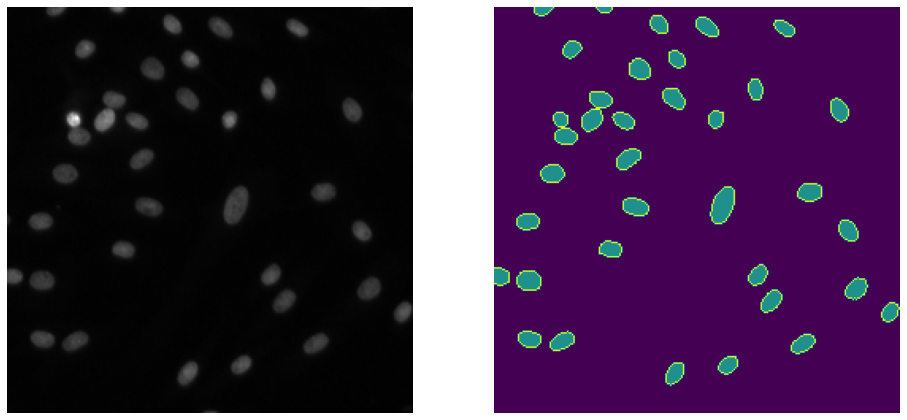

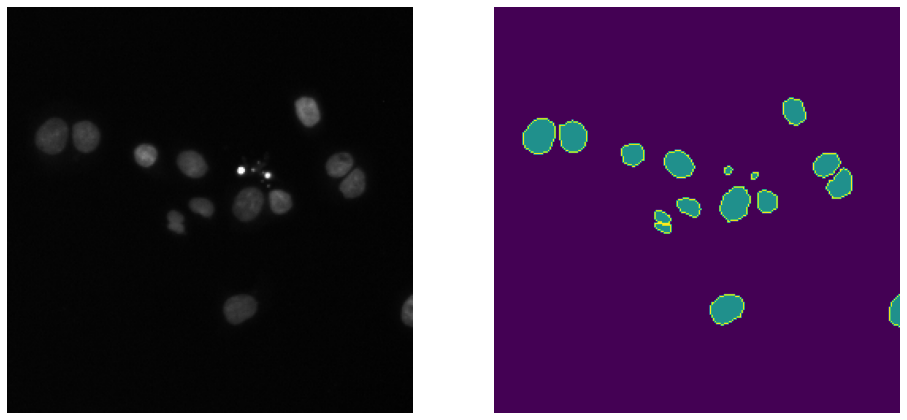

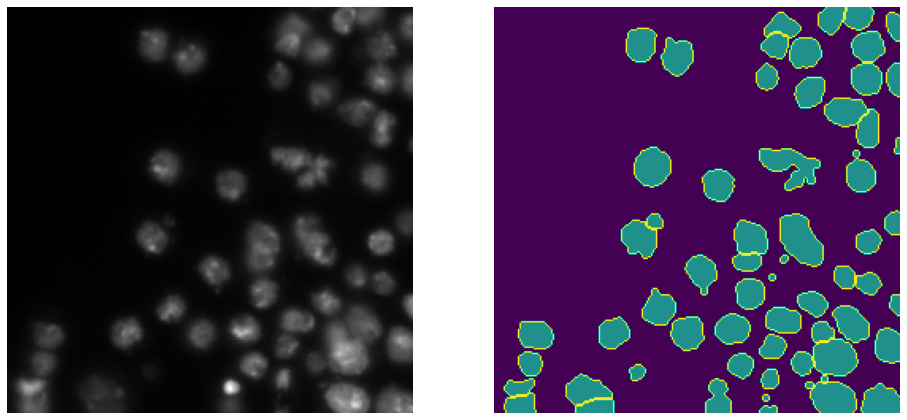

In [ ]:
# visualize the new label transform and make sure it's correct
counter = 0
for im, target in train_dataset:
    if counter > 3:
        break
    fig, ax = plt.subplots(1, 2, figsize=(16, 16))
    ax[0].axis("off")
    ax[0].imshow(im[0], cmap="gray")
    ax[1].axis("off")
    ax[1].imshow(target)
    plt.show()
    counter += 1

In [ ]:
# TODO instantiate the new unet and loss function
model = UNet(out_channels=3)
model.to(device)
loss = nn.CrossEntropyLoss()

In [ ]:
# train the new U-Net for 10 epochs
# (we don't use a metric here, since the target (with class labels 0, 1, 2) and prediction (one-hot encoding) have different representations
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = None

run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)

100%|██████████| 10/10 [04:51<00:00, 29.13s/it]


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.19392998575825582,
  0.18428172619844024,
  0.1333188426426866,
  0.0975521551868455,
  0.09301662148738449,
  0.09618086156181314,
  0.11714883233335885,
  0.08906832671808926,
  0.09331193735653703,
  0.09432467081668702])

In [ ]:
# TODO write instance segmentation function where you first subtract the  boundary from the foreground prediction,
# and then apply connected components to the result in order to get the instances
# the parameter 'threshold' should determine at which threshold the result is binarized before applying connected components 
# HINT: you can use skimage.segmentation.watershed (already implemented) afterwards to grow the segmentation back so that it
# covers the full prediction while keeping the instance labels
def instance_segmentation(foreground_prediction, boundary_prediction, threshold=0.5):
  difference = foreground_prediction - boundary_prediction
  difference = (difference > threshold).astype(np.uint8)

  labels = label(difference)

  return labels
  # return watershed(labels)

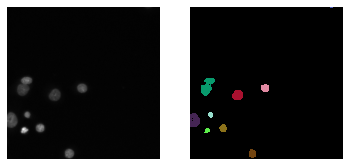

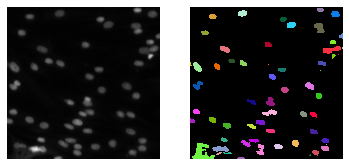

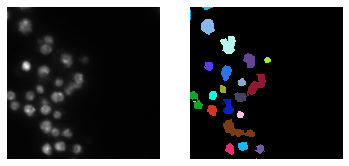

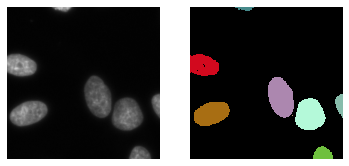

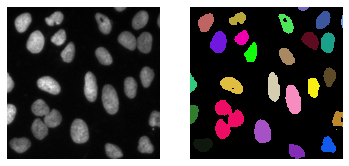

In [ ]:
# TODO check the prediction results and instance segmentation for a few images
# make sure your instance segmentation implementation is correct
# HINT: you need to apply a softmax to the network predictions 

def plot_sample(image, mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(np.squeeze(image), cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

for i, (x, y) in enumerate(train_loader):
  if i < 5:
    x = x.to(device)
    Y_pred = model(x)

    pred = torch.softmax(Y_pred, dim=1).detach().cpu().numpy().squeeze()
    nuclei = instance_segmentation(pred[1], pred[2], threshold=0.25)
    
    x = x.cpu().numpy()
    plot_sample(x, nuclei)

In [ ]:
# TODO use the validation set to find a good value for the 'threshold' parameter in the instance_segmentation function
best_threshold = 0.25

In [ ]:
# Compute the average IOU of all the test images
ious = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
    
        assert pred.shape[0] == 3
        nuclei = instance_segmentation(pred[1], pred[2])

        iou = intersection_over_union(nuclei, mask, best_threshold)
        ious.append(iou)
print()
print(np.mean(ious))

100%|██████████| 50/50 [00:02<00:00, 19.14it/s]


0.38507821921923785


QUESTIONS:
- Did training with the boundaries and using them in the instance segmentation improve the results?
- Can you think of ways to improve the loss function for this learning task?

1. Yes, it improved result
2. Weighted loss, where the separating background labels between touching cells obtain a large weight in the loss function 

## [Optional] Use the dice coefficient as loss function

Since our target is quite unbalanced (in particular the boundary channel), it can be benificial to use a balanced loss function. Here, we will use the Dice coefficient, which we have before used as metric, as loss function, since it is robust against unbalanced targets.
Note that we do not need to predict a channel with background prediction when using the dice coefficient as a loss (unlike with Cross Entropy).

In [ ]:
# TODO implement a loss function based on the dice coefficient
# HINT: the dice coefficient is in range [0, 1] and higher values correspond to a better result
# Loss functions are minimized, so lower values should correspond to a better result

In [ ]:
# TODO implement and compare with different loss function variations

## [Optional] Try variations of the UNet architecture

- add BatchNorm
- replace TransposedConvs with bilinear upsampling and 1x1 convs
- use residual blocks instead of the normal convolutional blocks

In [ ]:
# TODO implement and compare u-net architecture variations

## [Optional] Train with data augmentation

- rotations & flips
- noise augmentations (add gaussian noise and/or poisson noise)
- crop and resize

Hint: use the `image_transform` (noise augmentations) and `transform` (geometrical augmentations) argument of the `NucleiDataset`

In [ ]:
# TODO implement data augmentations and compare with training without augmentations

# Denoising with Noise2Noise

Here, we implement [Noise2Noise](https://arxiv.org/abs/1803.04189), which is a method to learn image denoising **without** ground-truth, by using a different noisy image as target. Note that we are re-using the same architecture as before, which is a bit different from the one used in the paper.

## Data Preparation

We use the [VSDR dataset](https://cv.snu.ac.kr/research/VDSR), which contains 'clean' (i.e. without noise) natural images.

In [ ]:
# Download the VSDR data
# !conda install -y gdown
# !gdown --id 1hNB5_MkxutrKLa1g35tSLCiq1J5xxH9F --folder

# os.makedirs("/kaggle/working/dlforcv-ex5", exist_ok=True)

# !unzip "/kaggle/working/VDSR/train_data.zip" -d "dlforcv-ex5/vsdr_train"
# !unzip "/kaggle/working/VDSR/test_data.zip" -d "dlforcv-ex5/vsdr_test"


from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/My Drive/VDSR/train_data.zip" -d "/kaggle/working/dlforcv-ex5/vsdr_train"
!unzip "/content/drive/My Drive/VDSR/test_data.zip" -d "/kaggle/working/dlforcv-ex5/vsdr_test"

Mounted at /content/drive
Archive:  /content/drive/My Drive/VDSR/train_data.zip
   creating: /kaggle/working/dlforcv-ex5/vsdr_train/291/
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t1.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t10.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t11.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t12.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t13.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t14.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t15.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t16.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t17.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t18.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t19.bmp  
  inflating: /kaggle/working/dlforcv-ex5/vsdr_train/291/000t2.bmp  
  inflating: /kaggle/working/dlforcv-

In [ ]:
# setting paths for the training and testing data
vsdr_train = "/kaggle/working/dlforcv-ex5/vsdr_train/"
vsdr_test = "/kaggle/working/dlforcv-ex5/vsdr_test/"

In [ ]:
# check the unique image sizes in the training data
image_exts = (".jpeg", ".jpg", ".png", ".bmp")
all_image_paths = [
    p for p in Path(vsdr_test).glob("**/*") if p.suffix.lower() in image_exts
]
shapes = []
for p in all_image_paths:
    shapes.append(imageio.imread(p).shape)
unique_shapes = list(set(shapes))
print(unique_shapes)

[(672, 1024, 3), (768, 1024, 3), (980, 1000, 3), (656, 529, 3), (681, 1024, 3), (656, 1024, 3), (1024, 768, 3), (819, 1024, 3), (769, 1024, 3), (481, 321, 3), (695, 1024, 3), (683, 1024, 3), (673, 1024, 3), (805, 1024, 3), (344, 228, 3), (827, 1200, 3), (512, 512), (362, 500, 3), (1200, 798, 3), (512, 768, 3), (680, 1024, 3), (1024, 1005, 3), (963, 1280, 3), (288, 352, 3), (1024, 567, 3), (766, 1024, 3), (732, 1024, 3), (682, 1024, 3), (1037, 778, 3), (692, 1024, 3), (676, 1024, 3), (727, 1024, 3), (276, 276, 3), (864, 1024, 3), (288, 288, 3), (835, 1024, 3), (694, 1024, 3), (512, 512, 3), (616, 1024, 3), (280, 280, 3), (576, 1024, 3), (1024, 692, 3), (1024, 1024, 3), (678, 1024, 3), (1024, 685, 3), (1024, 683, 3), (644, 1024, 3), (773, 1024, 3), (797, 1024, 3), (256, 256, 3), (689, 1024, 3), (765, 1024, 3), (480, 500, 3), (391, 586, 3), (737, 1024, 3), (1024, 742, 3), (660, 1024, 3), (321, 481, 3), (576, 720, 3), (665, 1024, 3), (1024, 700, 3), (575, 1024, 3), (361, 250, 3)]


In [ ]:
# vsdr dataset that can deal with all the different data sizes in the training and test data
class VsdrDataset(Dataset):
    def __init__(self, root_dir, noise_transform):
        image_exts = (".jpeg", ".jpg", ".png", ".bmp")
        self.image_paths = [
            p for p in Path(root_dir).glob("**/*") if p.suffix.lower() in image_exts
        ]
        self.noise_transform = noise_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        im = np.array(imageio.imread(self.image_paths[index]))
        if im.ndim == 2:
            im = np.concatenate([im[..., None]] * 3, axis=2)
        if im.shape[-1] == 1:
            im = np.concatenate([im] * 3, axis=2)
        target_shape = (256, 256)
        # first, pad the images if they are smaller than the target crop shape
        if any(sh < tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            padding = tuple((0, tsh - sh if sh < tsh else 0) for sh, tsh in zip(im.shape[:-1], target_shape))
            padding = padding + ((0, 0),)
            im = np.pad(im, padding, mode="reflect")
        # then crop tham if they are too large
        if any(sh > tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            crop_start = [np.random.randint(0, sh - tsh) if sh != tsh else 0 for sh, tsh in zip(im.shape[:-1], target_shape)]
            crop = tuple(slice(cs, cs + tsh) for cs, tsh in zip(crop_start, target_shape))
            im = im[crop]
        assert im.shape == (256, 256, 3), f"{im.shape}"
        
        # normalize the image to range [0, 1] (per channel)
        im = im.astype(np.float32)
        im -= im.min(axis=(0, 1), keepdims=True)
        im /= im.max(axis=(0, 1), keepdims=True)
        # bring image in range [-1, 1]
        im = 2 * im - 1
        
        # transform to channel first order
        im = im.transpose((2, 0, 1))
        # apply the noise transformation
        return self.noise_transform(im)

In [ ]:
# go from range [-1, 1] to [0, 255] and uint 8
# and go to channel last order
def to_display(im):
    im = (((im + 1) / 2) * 255).astype("uint8")
    return im.transpose((1, 2, 0))

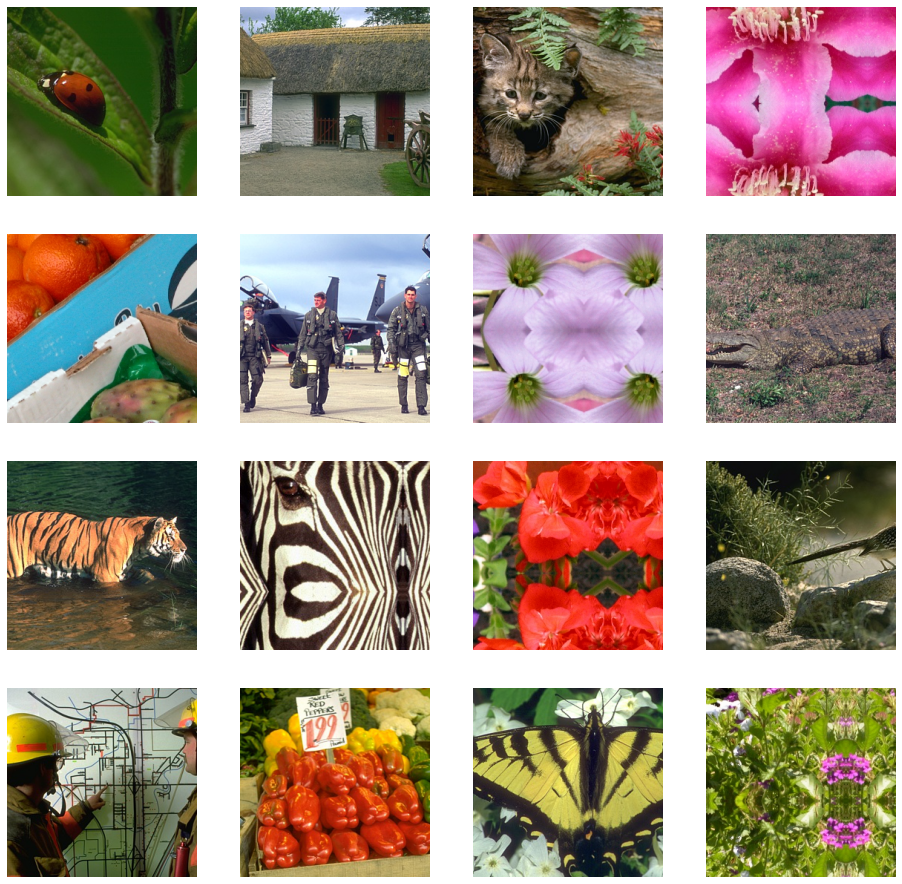

In [ ]:
# sample a few images
check_dataset = VsdrDataset(vsdr_train, lambda x: x)
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for ii in range(16):
    im = check_dataset[ii]
    ax[ii % 4, ii // 4].axis("off")
    ax[ii % 4, ii // 4].imshow(to_display(im))
plt.show()

## Train a network with clean targets

As the first baseline, we will train a network with clean target data (i.e. without noise added to it). 

In [ ]:
# instatiate the model and loss function (Mean Squared Error)
model = UNet(in_channels=3, out_channels=3)
model.to(device)
loss = nn.MSELoss()
loss.to(device)

MSELoss()

In [ ]:
# we will use the PSNR (peak signal to noise ratio) as metric to evaluate the predictions.
# you can read up on it and the implementation we are using here:
# https://www.ni.com/en-us/innovations/white-papers/11/peak-signal-to-noise-ratio-as-an-image-quality-metric.html
# (the higher the PSNR, the better)

def to_uint8(im):
    return torch.clamp((im + 0.5) * 255.0 + 0.5, 0, 255).type(torch.uint8)


class PSNR(nn.Module):
    def __call__(self, x, y):
        x, y = to_uint8(x), to_uint8(y)
        x, y = x.detach().cpu().numpy(), y.detach().cpu().numpy()
        return peak_signal_noise_ratio(x, y)

QUESTION:
- What does the PSNR metric measuere?
- Why is it used instead of 'just' computing the pixel wise error (MSE)?

1. It is a quality measurement (amount of noise) between two images. It is defined my maximum signal to noise ratio
2. It allows to work with images in different color spaces

In [ ]:
# TODO implement a function that adds additive gaussian noise to the input
# the var argument should correspond to the variance of the gaussian
def additive_gaussian_noise(x, var):
  return (x + np.random.randn(*x.shape) * np.sqrt(var)).astype(np.float32)


In [ ]:
# TODO instantiate a vsdr dataset corresponding to the vsdr_train folder 
# with a noise transformation that returns a corrupted image (as network input)
# and a clean image (as target)
# use a variance of 0.1
# split the dataset into a train (90% of the data) and validationd dataset (10%)
# HINT: you can use torch.utils.data.random_split to split a torch dataset
dataset = VsdrDataset(vsdr_train, lambda x: (additive_gaussian_noise(x, 0.1), x))
vsdr_train_ds, vsdr_val_ds = torch.utils.data.random_split(dataset, (0.9, 0.1))

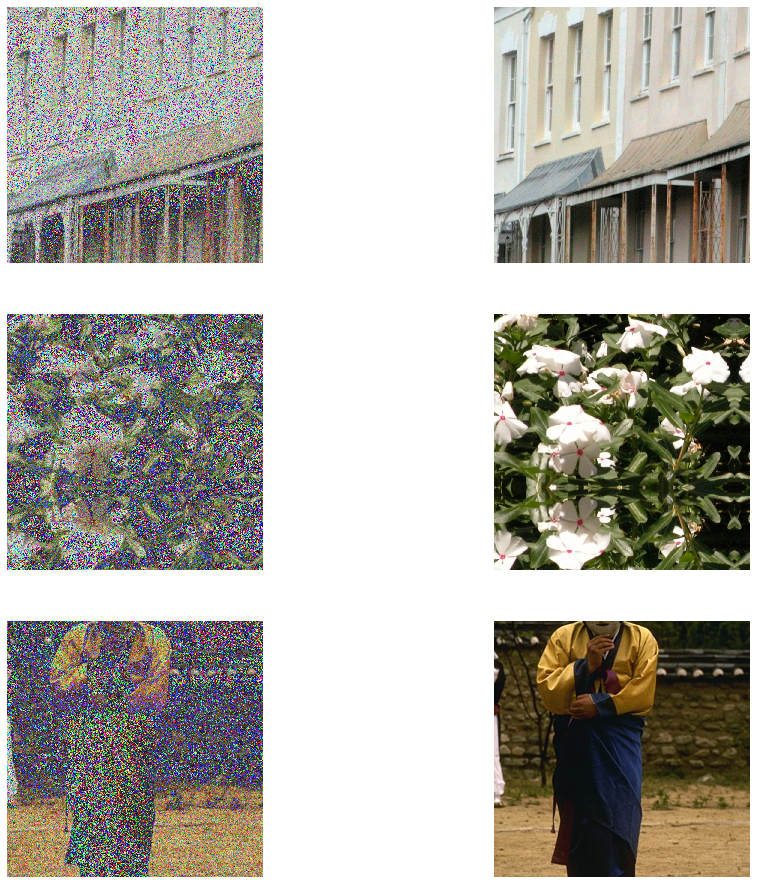

In [ ]:
# sample a few images from the train dataset
fig, ax = plt.subplots(3, 2, figsize=(16, 16))
for ii in range(3):
    noisy, clean, = vsdr_train_ds[ii]
    # go back to uint8
    ax[ii, 0].axis("off")
    ax[ii, 0].imshow(to_display(noisy))
    ax[ii, 1].axis("off")
    ax[ii, 1].imshow(to_display(clean))
plt.show()

In [ ]:
# train the denoising network
n_epochs = 10
# logger = SummaryWriter("runs/noise2noise-1")
train_loader = DataLoader(vsdr_train_ds, batch_size=1, shuffle=True) 
val_loader = DataLoader(vsdr_val_ds, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = PSNR()
run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)

 10%|█         | 1/10 [33:48<5:04:20, 2028.97s/it]

In [ ]:
# create the test dataset
vsdr_test_ds = VsdrDataset(
    vsdr_test,
    noise_transform=lambda x: (additive_gaussian_noise(x, var=0.1), x)
)

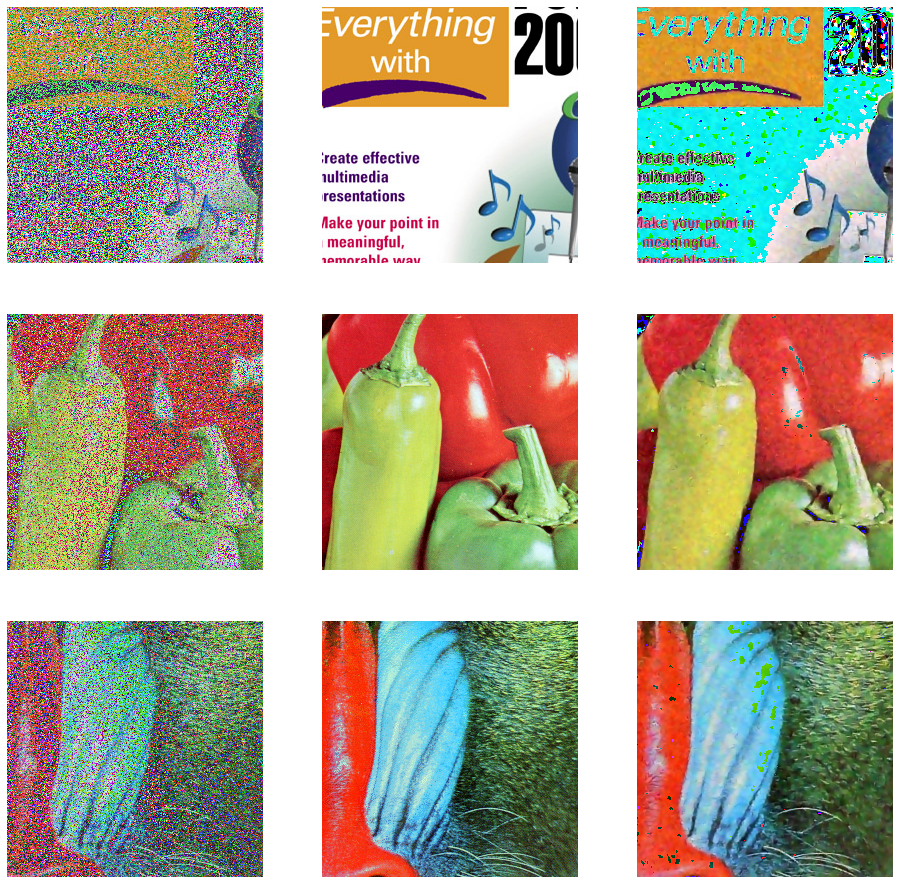

In [ ]:
# TODO display some results on the test data

test_loader = DataLoader(vsdr_test_ds, batch_size=1)

fig, ax = plt.subplots(3, 3, figsize=(16, 16))

for index, (image, target) in enumerate(test_loader):
  if index == 3: 
    break

  image = image.to(device)
  res = model(image).detach().cpu().numpy().squeeze()

  image = image.cpu().numpy().squeeze()
  target = target.numpy().squeeze()

  ax[index, 0].axis("off")
  ax[index, 0].imshow(to_display(image))
  ax[index, 1].axis("off")
  ax[index, 1].imshow(to_display(target))
  ax[index, 2].axis("off")
  ax[index, 2].imshow(to_display(res))

plt.show()


In [ ]:
scores = []
psnr = PSNR()

for image, target in test_loader:
  image = image.to(device)
  res = model(image)
  scores = psnr(res, target)

print(np.mean(scores))

20.606993394772154


## Train a network with noisy targets (Gaussian noise)

Now, we train a network from noisy inputs AND noisy targets. And compare its results to the previous denoising network learned on clean targets.

QUESTION:
- Why can the model learn denoising even though we also have a noisy target?

1. Zero-mean noise does not affect loss function, therefore model trains the same way as with noiseless images

In [ ]:
# instantiate new model and loss
model = UNet(in_channels=3, out_channels=3)
model.to(device)
loss = nn.MSELoss()
loss.to(device)

MSELoss()

In [ ]:
# TODO create dataset with corrupted input and target
# use same variance as before (0.1)
dataset = VsdrDataset(vsdr_train, lambda x: (additive_gaussian_noise(x, 0.1), additive_gaussian_noise(x, 0.1)))
vsdr_train_ds, vsdr_val_ds = torch.utils.data.random_split(dataset, (0.9, 0.1))

In [ ]:
# train the model
n_epochs = 10
train_loader = DataLoader(vsdr_train_ds, batch_size=1, shuffle=True) 
val_loader = DataLoader(vsdr_val_ds, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = PSNR()
run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)

100%|██████████| 10/10 [05:21<00:00, 32.16s/it]


([12.87789843526814,
  13.045749265209936,
  12.955233540848281,
  13.027056797743152,
  13.15781848809707,
  13.171946901668115,
  13.03121267438192,
  12.906422511606248,
  13.156557380297352,
  13.162690230624095],
 [0.11797088600302998,
  0.11427099767484163,
  0.11327581068402842,
  0.1140323018557147,
  0.11219384521245956,
  0.11197919771075249,
  0.1125918430717368,
  0.11300951536548764,
  0.11850246336115033,
  0.11795317322800034])

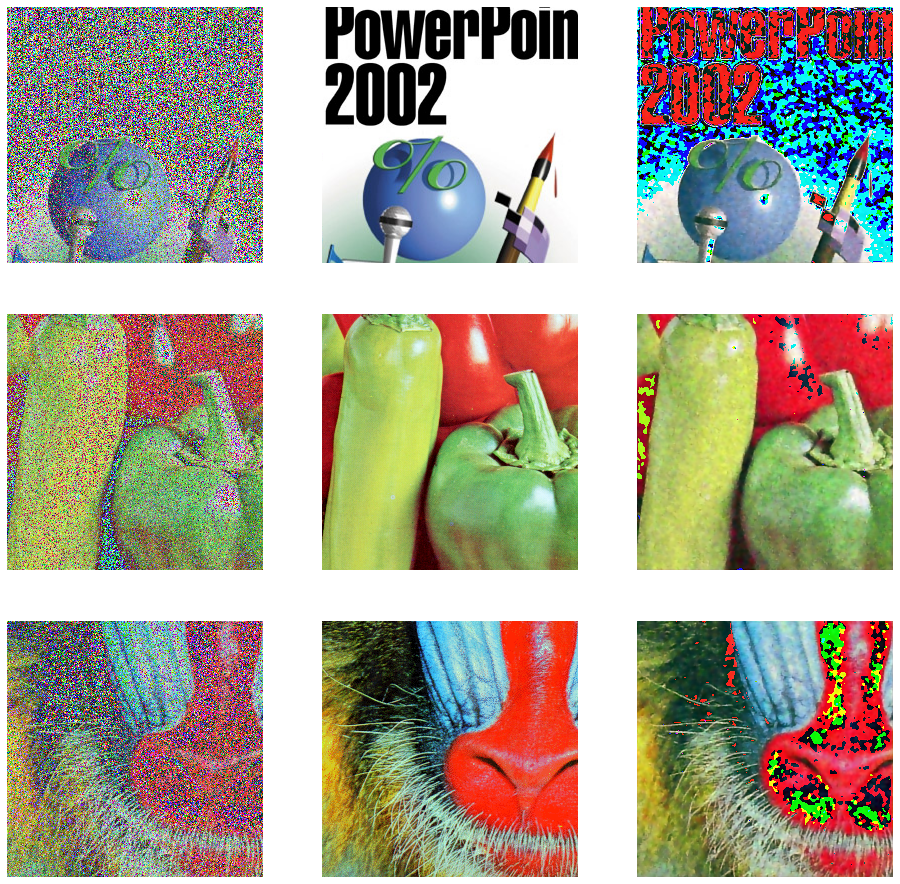

In [ ]:
# TODO show a few predictions for the test dataset

test_loader = DataLoader(vsdr_test_ds, batch_size=1)

fig, ax = plt.subplots(3, 3, figsize=(16, 16))

for index, (image, target) in enumerate(test_loader):
  if index == 3: 
    break

  image = image.to(device)
  res = model(image).detach().cpu().numpy().squeeze()

  image = image.cpu().numpy().squeeze()
  target = target.numpy().squeeze()

  ax[index, 0].axis("off")
  ax[index, 0].imshow(to_display(image))
  ax[index, 1].axis("off")
  ax[index, 1].imshow(to_display(target))
  ax[index, 2].axis("off")
  ax[index, 2].imshow(to_display(res))

plt.show()

In [ ]:
# TODO compute the PSNR for the whole test dataset

scores = []
psnr = PSNR()

for image, target in test_loader:
  image = image.to(device)
  res = model(image)
  scores = psnr(res, target)

print(np.mean(scores))

20.216207409155


QUESTIONS:
- Compare the result between the network trained with clean targets and with noisy targets.

1. Model trained with Noise2Noise performes worser. Its average PSNR value is little bit lower

## [Optional] Train a network with noisy targets (Poisson noise)

Use poisson noise instead of gaussian noise and compare to both the network trained with clean target and the network with the target corrupted by gaussian noise.

In [ ]:
# TODO run training with poisson noise and compare with previous results

## [Optional] Use U-Net with BatchNorm

Repeat the exercise with a U-Net with BatchNorm. Does this improve the results?

In [ ]:
# TODO use a U-Net architecture with BatchNorm and compare with previous results